# NP Expression and Co-Expression Mapper

In [1]:
# Important to keep this in sync whenever renaming this notebook
notebook_name = 'NP_Scope'

# Import modules
import pymap as pm # SJS module: pymap.py must reside in current directory
import json
import shutil
import psutil
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.patches import Rectangle, Polygon
from matplotlib.backends.backend_pdf import PdfPages

# Make some choices...
dataset = 'Y21ss'
#dataset = 'Y21tenX'
#dataset = 'Y23'
#dataset = 'H19'

datasubset = 'NP'
#datasubset = 'nMod'

if dataset[0] == 'Y': # Path for tables specific to species but not to dataset
    species = 'mouse'
    tables_path = 'Resources/Mouse_tables/'
else:
    species = 'human'
    tables_path = 'Resources/Human_tables/'    
    
sns.set_theme(font_scale=1.3, rc={'patch.linewidth': 0})

# Assemble the general filepaths
name_root = notebook_name
results_path = 'Products/'+name_root+'/'
pdf_path = results_path+'PDFs/'
csv_path = results_path+'CSVs/'
zip_path = results_path+'ZIPs/'
temp_path = 'Temp/'

#for dataset in dataset_list:

# Read annotated expression data
source_path = 'Resources/'+dataset+'_'+datasubset+'_counts.csv.zip'
support_path = 'Resources/'+dataset+'_'+datasubset+'_support.json'

print('Reading',source_path)
df = pd.read_csv(source_path)
anno_counts = df.copy()

# Read support dictionary
with open(support_path, 'r') as fp:
    support_dict = json.load(fp)

# Extract annotation value dictionaries
region_colors = dict(zip(anno_counts['region'],anno_counts['region_color']))
class_colors = dict(zip(anno_counts['class'],anno_counts['class_color']))
class_colors = {key: class_colors[key] for key in sorted(class_colors)}
subclass_colors = dict(zip(anno_counts['subclass'],anno_counts['subclass_color']))
subclass_colors = {key: subclass_colors[key] for key in sorted(subclass_colors)}
subclass_zones = dict(zip(anno_counts['subclass'],anno_counts['class']))
subclass_zones = {key: subclass_zones[key] for key in sorted(subclass_zones)}
subclass_shorts = dict(zip(anno_counts['subclass'],anno_counts['subclass']))
subclass_shorts = {key: subclass_shorts[key].split(' ',1)[1] for key in sorted(subclass_shorts)}
cluster_colors = dict(zip(anno_counts['cluster'],anno_counts['cluster_color']))
cluster_colors = {key: cluster_colors[key] for key in sorted(cluster_colors)}
cluster_zones = dict(zip(anno_counts['cluster'],[s.split(' ',1)[1] for s in anno_counts['cluster']]))
cluster_zones = {key: cluster_zones[key] for key in sorted(cluster_zones)}

# Read CSV table to form region dictionaries
df = pd.read_csv('Resources/'+dataset+'_region_table.csv')
region_shorts = df.set_index('region_label')['region_short'].to_dict()
region_zones = df.set_index('region_label')['zone'].to_dict()

# Form annotation unique value lists
types = (list(set(anno_counts['type']))); types.sort()
regions = list(region_colors.keys())
classes = list(class_colors.keys())
subclasses = list(subclass_colors.keys())
clusters = list(cluster_colors.keys())

if dataset == 'Y23': # 'supertypes' in Y23 dataset only
    supertype_colors = dict(zip(anno_counts['supertype'],anno_counts['supertype_color']))
    supertype_colors = {key: supertype_colors[key] for key in sorted(supertype_colors)}
    supertypes = list(supertype_colors.keys())

if dataset[0:3] == "Y21": # 'neighborhood' in Y21 datasets only
    neighborhood_colors = dict(zip(anno_counts['neighborhood'],anno_counts['neighborhood_color']))
    neighborhood_colors = {key: neighborhood_colors[key] for key in sorted(neighborhood_colors)}
    neighborhoods = list(neighborhood_colors.keys())
    # Remove any unwanted list items
    subclasses.remove('01 CR')
    subclasses.remove('02 Meis2')

# Read CSV table to form gene label dictionary
df = pd.read_csv(tables_path + 'All_nMods_labeled.csv')
gene_labels = df.set_index('Symbol').to_dict()['Label']

# Configure multiindex
major_annos = ['type','region','class','subclass','cluster','counts_sum']
all_annos = support_dict['annotation_labels']
minor_annos = [s for s in all_annos if s not in major_annos]
anno_counts.drop(columns=minor_annos, inplace=True)
anno_counts.set_index(major_annos, inplace=True)

# Sanity check
if species == 'mouse':
    print('Sanity check:\n'+str(anno_counts[['Cck','Npy','Vip','Cckbr','Kng1','Bdkrb1']].sum()))
    
else:
    print('Sanity check:\n'+str(anno_counts[['CCK','NPY','VIP','CCKBR','KNG1','BDKRB1']].sum()))

# Use conjugate pair table to generate aggregate NP_GPCRs conjugate to a set of NPPs

# Read pair table
pair_table = pd.read_csv(tables_path + 'NP_pairs.csv')
pair_table['Pair Label'] = pair_table['NPP'] + '->' + pair_table['NP-GPCR']
pair_id = list(pair_table['Pair ID'])
pair_npps = list(pair_table['NPP'])
pair_nprs = list(pair_table['NP-GPCR'])
pair_labels = list(pair_table['Pair Label'])
pair_table.set_index('Pair ID', inplace=True)

# Build cognate NPP/aggregate-NP-GPCRs dictionary
df = pair_table[['NPP','NP-GPCR']].set_index('NPP').copy()
df['Aggs'] = df['NP-GPCR']+' '
df = df.groupby('NPP').sum()
npp_cogs_dict = df['Aggs'].to_dict()
for npp in npp_cogs_dict: npp_cogs_dict[npp] = npp_cogs_dict[npp].split()

# Build dataframe with aggregated NP-GPCRs conjugate to included NPPs
npp_list = list(pd.read_csv(tables_path + '20NPPs.csv')['Symbol'])
gene_order = npp_list

df = anno_counts[npp_list].copy()
for npp in npp_list: df[npp+'Rs'] = anno_counts[npp_cogs_dict[npp]].sum(axis=1)
npr_list = [x+'Rs' for x in npp_list]
counts = df.copy()
hots = (counts>=1).astype(int)
df_sum = df.index.get_level_values('counts_sum')
cpm = 1e6 * (df.T / df_sum).T 

npps = cpm[npp_list].copy()
nprs = cpm[npr_list].copy()
npps.columns = [s+'*' for s in npps.columns] 
nprs.columns = npps.columns
prods = npps * nprs

bnpps = hots[npp_list].copy()
bnprs = hots[npr_list].copy()
bnpps.columns = [s+'*' for s in bnpps.columns] 
bnprs.columns = bnpps.columns
bprods = bnpps * bnprs

# Get the memory usage in percentage
print(f"Memory usage: {psutil.virtual_memory().percent}%")

Reading Resources/Y21ss_NP_counts.csv.zip
Sanity check:
Cck       116533554
Npy       125621823
Vip       196035630
Cckbr       5525715
Kng1           4702
Bdkrb1         1859
dtype: int64
Memory usage: 59.4%


In [12]:
# Region stats by class
# Setup for Multi-mapper cell
major_list = ['00 All']+classes
major_label = 'class'
minor_label = 'region'
color_dict = region_colors
shorts_dict = region_shorts
zone_dict = region_zones
min_tally = 10
map_label = 'Region Stats for Class'


In [9]:
# Subclass stats by region
# Setup for Multi-mapper cell
major_list = regions
major_label = 'region'
minor_label = 'subclass'
color_dict = subclass_colors
shorts_dict = subclass_shorts
zone_dict = subclass_zones
min_tally = 10
map_label = 'Region'


In [ ]:
# Cluster stats by subclass
# Setup for Multi-mapper cell
major_list = subclasses
major_label = 'subclass'
minor_label = 'cluster'
color_dict = cluster_colors
shorts_dict = None
zone_dict = cluster_zones
min_tally = 10
map_label = 'Cluster Stats for Subclass'


In [10]:
major_list

['001 VISp',
 '002 VIS',
 '005 PTLp',
 '006 AUD',
 '007 SSp',
 '009 SSs',
 '010 GU',
 '011 MOp',
 '012 ALM',
 '014 CLA',
 '016 PL-ILA',
 '017 ORB',
 '018 AI',
 '019 ACA',
 '020 RSP',
 '021 TEa-PERI-ECT',
 '023 ENTm',
 '024 ENTl',
 '025 PAR-POST-PRE',
 '027 SUB-ProS',
 '028 HIP']

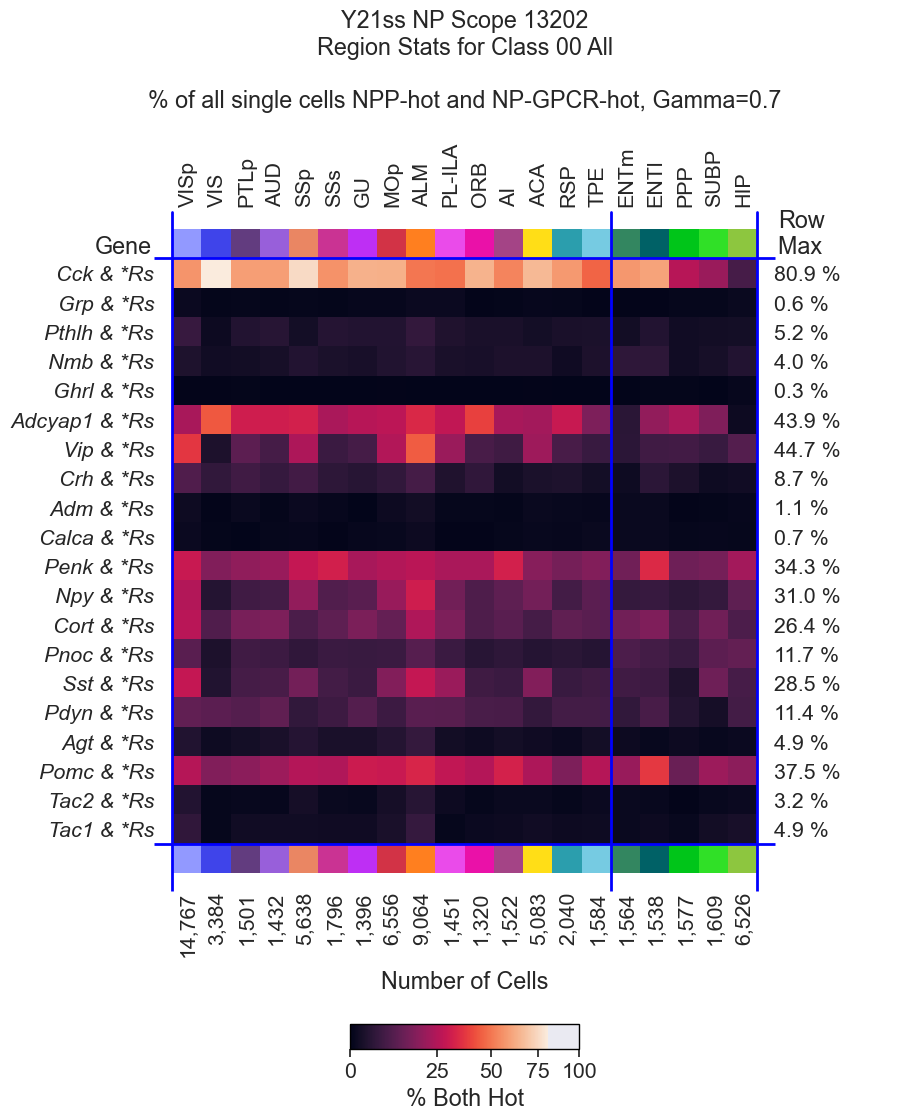

Y21ss_NP_Scope_class00_%ofAll_13202.csv written to Products/NP_Scope/ZIPs/Y21ss_NP_Scope_region_13202.zip


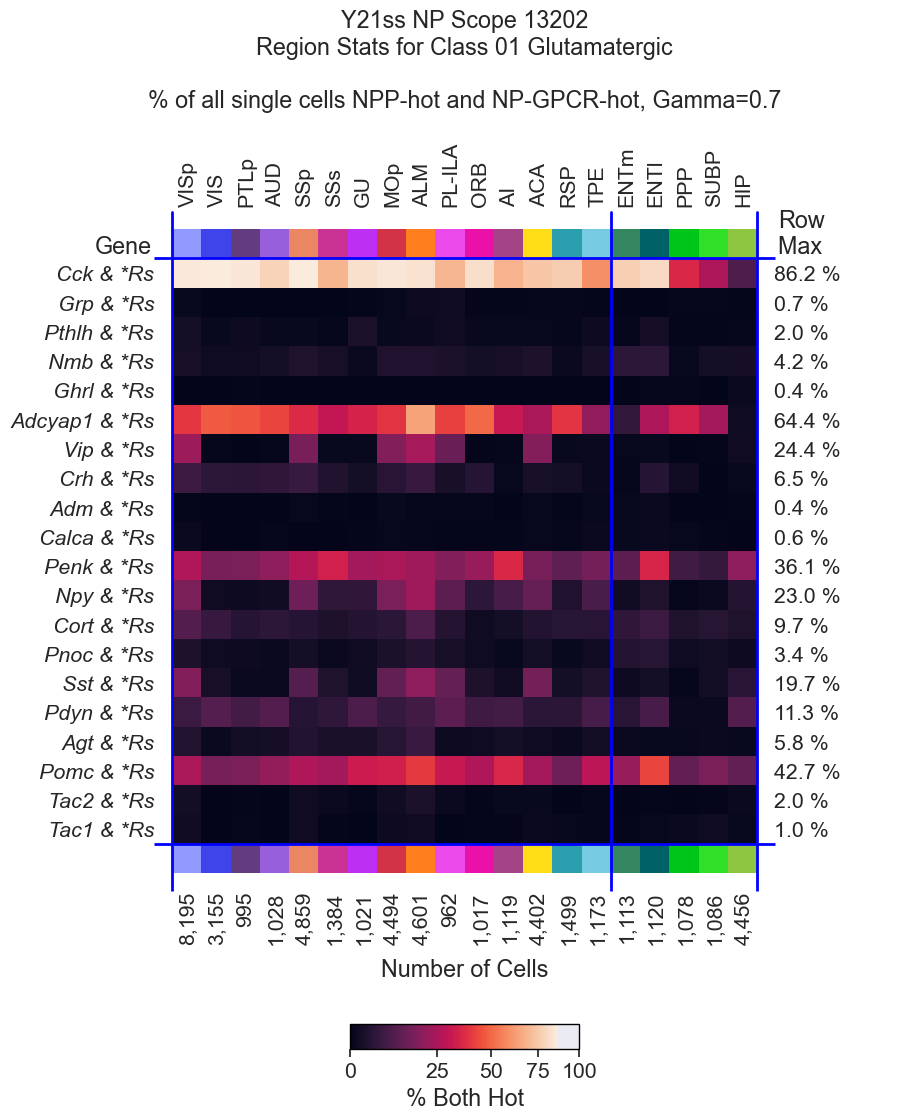

Y21ss_NP_Scope_class01_%ofAll_13202.csv written to Products/NP_Scope/ZIPs/Y21ss_NP_Scope_region_13202.zip


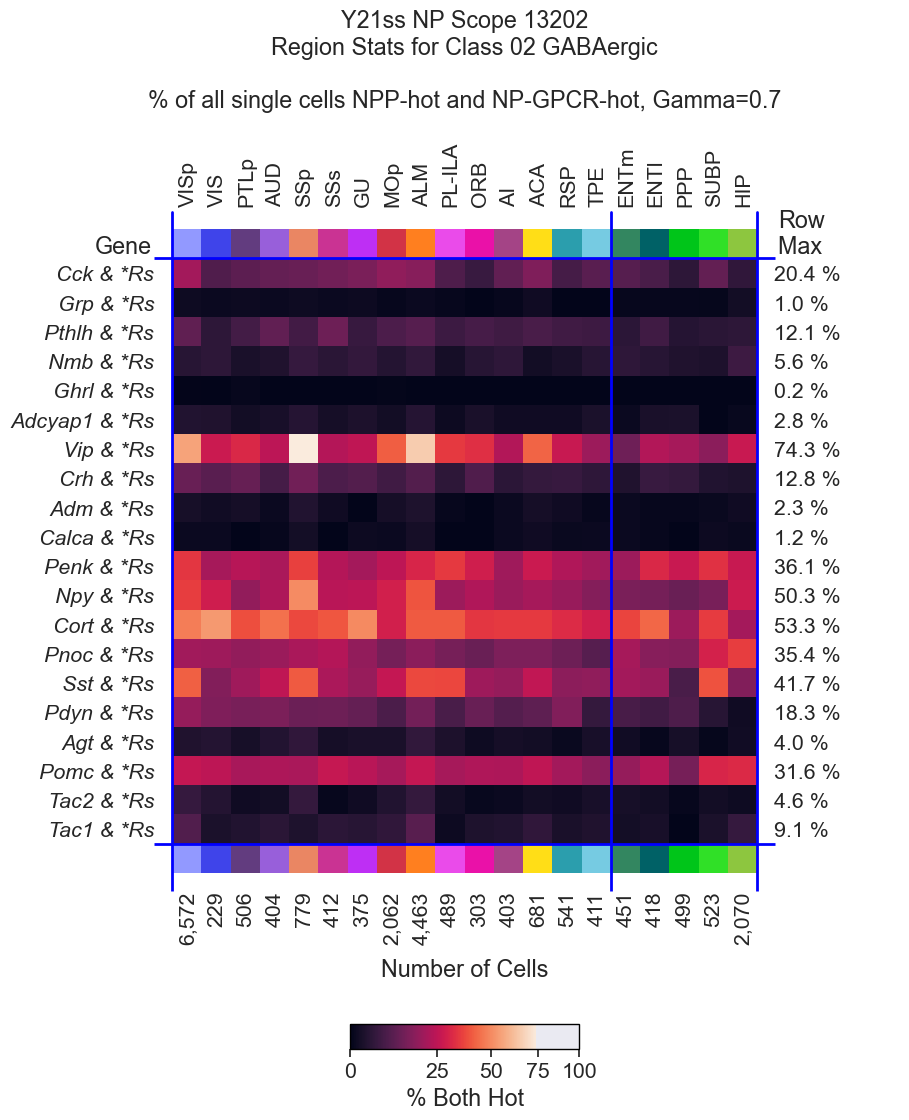

Y21ss_NP_Scope_class02_%ofAll_13202.csv written to Products/NP_Scope/ZIPs/Y21ss_NP_Scope_region_13202.zip


In [13]:
# Multi-mapper
# Map %NPco's after setup, write results to a PDF and a ZIP archive of CSVs

row_stat = 'max' # 'max' or 'mean'
row_norm = False
row_sort = False
row_sort_all = False
perc_gamma = 0.7
#log_floor_coef = 0.01
handle = dataset+'_'+notebook_name+'_'

# Get a serial number and save a copy of this notebook
sn = pm.serial(5)
source_notebook_path = notebook_name+'.ipynb'
destination_notebook_path = 'Notebooks/'+notebook_name+'_'+sn+'.ipynb'
shutil.copy2(source_notebook_path, destination_notebook_path)

csv_file = csv_path+handle+minor_label+'_'+sn+'.csv'
zip_file = zip_path+handle+minor_label+'_'+sn+'.zip'
temp_csv = temp_path+'temp.csv'
pdf = PdfPages(results_path+'PDFs/'+handle+minor_label+'_'+sn+'.pdf')

sns.set_theme(font_scale=1.4, rc={'patch.linewidth': 0})
types = ['01 Neuronal']
#types = ['02 Glial']

zip_mode = 'w'
idx = pd.IndexSlice
for major in major_list:
    if major_label == 'class':
        if major == '00 All': gate = types,regions,classes,subclasses
        else: gate = types,regions,major,subclasses
    if major_label == 'region': gate = types,major,classes,subclasses
    if major_label == 'subclass': gate = types,regions,classes,major
    for i, metric in enumerate(['%ofAll']): #,'%NPP+','NPP','%NPR+','NPR','%ofNPP+','%ofNPR+']):
        units = ' %' if '%' in metric else ''
        log = False if '%' in metric else True        
        try: df = npps.loc[idx[gate], :]
        except KeyError: continue
        metric_label = map_label+' '+major+'\n\n'
        if metric == 'NPP':
            df = npps.loc[idx[gate], :]
            metric_label += 'Mean NPP CPM'
        if metric == '%NPP+':
            df = bnpps.loc[idx[gate], :]
            metric_label += '% of all single cells NPP-hot'
        if metric == 'NPR':
            df = nprs.loc[idx[gate], :]
            metric_label += 'Mean NP-GPCR CPM'
        if metric == '%NPR+':
            df = bnprs.loc[idx[gate], :]
            metric_label += '% of all single cells NP-GPCR-hot'
        if metric == '%ofAll': # Note: NaN values operate here
            df = bprods.loc[idx[gate], :]
            metric_label += '% of all single cells NPP-hot and NP-GPCR-hot'
        if metric == '%ofNPP+': # Note: NaN values operate here
            df = bprods.loc[idx[gate], :]
            df = df / bnpps.loc[idx[gate], :]
            metric_label += '% of NPP-hot single cells also NP-GPCR-hot'
        if metric == '%ofNPR+': # Note: NaN values operate here
            df = bprods.loc[idx[gate], :]
            df = df / bnprs.loc[idx[gate], :]
            metric_label += '% of NP-GPCR-hot single cells also NPP-hot'
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.groupby(minor_label).filter(lambda x: len(x) >= min_tally) # filter out small groups
        if len(df) == 0: continue
        grouped = df.groupby(minor_label)
        
        title = handle.replace('_',' ')+sn+'\n'+metric_label
        if '%' in metric:
            gamma = perc_gamma
            title += ', Gamma='+str(gamma)
            df = 100 * grouped.mean()
            units = ' %'
            cbar_label = '% Both Hot' if '%of' in metric else '% Hot' 
        else:
            gamma = 1.0
            df = grouped.mean()
            units = ''
            cbar_label = 'Mean CPM'
            
        if i == 0 or row_sort_all:
            if row_sort: 
                if row_stat == 'max': gene_order = list(df[df.max().sort_values(ascending=False).index].columns)
                if row_stat == 'mean': gene_order = list(df[df.mean().sort_values(ascending=False).index].columns)
            else: gene_order = list(df.columns)
            cell_tally = grouped.count().iloc[:,0]
            vlines = []; zone = []
            for i, minor in enumerate(df.index):
                if zone_dict[minor] != zone: vlines += [i]; zone = zone_dict[minor]
            vlines += [len(df)]
        df = df[gene_order].copy()
        if metric in ['NPP','%NPP+']: df.columns = [s for s in [s.split('*')[0] for s in list(df.columns)]]
        if metric in ['NPR','%NPR+']: df.columns = [s+'*R' for s in [s.split('*')[0] for s in list(df.columns)]]
        if '%of' in metric: df.columns = [s+' & *Rs' for s in [s.split('*')[0] for s in list(df.columns)]]
        X = df.T
        colors = [color_dict[s] for s in list(X.columns)]
        if shorts_dict != None: X.columns = [shorts_dict[s] for s in list(X.columns)]
        # Plot the heatmap        
        pm.draw_heatmap(X,cell_tally, colors, title, pdf, row_norm=row_norm, row_sort=False, gamma=0.7,
                                    row_stat = row_stat, vlines=vlines, units=units, log=log, slant=90,
                                    cbar=True, cbar_label=cbar_label)
            
        if metric == 'NPP':
            mat1 = X.T.copy()
            label1 = metric
        if metric == '%ofAll':
            mat2 = X.T.copy()
            label2 = metric

        # Append a cell tally row to X and start the CSV zip archive
        X.loc['cells'] = list(cell_tally)
        X.to_csv(temp_csv)
        with zipfile.ZipFile(zip_file, zip_mode) as zipf:
            arc_name = handle+major_label+major.split()[0]+'_'+metric+'_'+sn+'.csv'
            zipf.write(temp_csv, arcname=arc_name)
        zip_mode = 'a'
        print(arc_name,'written to',zip_file)

pdf.close()

In [ ]:
major_list

In [ ]:
# Scatter % both hot vs. mean NPP for each pair

pdf = PdfPages(results_path+'PDFs/'+dataset+'_scatter_'+sn+'.pdf')

columns = mat2.columns
mat1.columns = columns

for gene in list(columns):
    plt.scatter(mat1[gene], mat2[gene])
    
    # Add labels and title
    plt.title('Scatter for '+gene)
    plt.xlabel(label1)
    plt.ylabel(label2)

    pdf.savefig(dpi=300, transparent=True, bbox_inches='tight', pad_inches=0.2)
    plt.show()
    
pdf.close()

In [ ]:
mat1

In [ ]:
# Plot a histogram for each gene

pdf = PdfPages(results_path+'PDFs/'+dataset+'_histos_'+sn+'.pdf')

for gene in list(cpm.columns):
    cpm[gene].plot.hist(bins=100, alpha=0.7, range=(0,50), log=True)

    # Add labels and title
    plt.title('Histogram of '+dataset+' '+gene+' Values')
    plt.xlabel('CPM')
    plt.ylabel('Frequency')
    
    stat = '99%ile CPM = ' + str(round(cpm[gene].quantile(0.99), 1))
    plt.text(0.5, 0.9, stat, fontsize=14, color='k', ha='center',
             transform=plt.gca().transAxes)

    
    pdf.savefig(dpi=300, transparent=True, bbox_inches='tight', pad_inches=0.2)
    plt.show()
    
pdf.close()

In [ ]:
bprods

In [ ]:
# Optional to control cognate list generation

cogs = 'separate'
#cogs = 'first'
#cogs = 'top_frac'
#cogs = 'top_mean'

# Build dataframe with aggregated NP-GPCRs conjugate to included NPPs
npp_list = list(pd.read_csv(tables_path + '20NPPs.csv')['Symbol'])
gene_order = npp_list
df = anno_counts[npp_list].copy()

if cogs == 'separate': # keep cogs separate
    for npp in npp_list:
        for npr in npp_cogs_dict[npp]:
            print(npp, npr)
        df[npp+'Rs'] = anno_counts[npp_cogs_dict[npp]].sum(axis=1)
        
if cogs == 'aggregate': # aggregate all cogs and set agg names
    for npp in npp_list: df[npp+'Rs'] = anno_counts[npp_cogs_dict[npp]].sum(axis=1)
    npr_list = [x+'Rs' for x in npp_list]


In [ ]:
# Tally all NPPs
df = anno_counts.loc['01 Neuronal']
npp_tallies = df[npp_list].sum()
df = pd.DataFrame(npp_tallies)
df.to_csv(results_path+dataset+'_npp_tallies.csv')

In [ ]:
# Hack to zero in on bed nucleus
subclasses = [s for s in subclasses if 'BST' in s]
regions = ['018 STRd','019 STRv','020 LSX','021 sAMY','022 PAL']

In [ ]:
round(cpm['Cck'].max(), 1)

In [ ]:
bg_regns =  ['018 STRd','019 STRv','020 LSX','021 sAMY','022 PAL']

In [ ]:
subclasses

In [ ]:
[s for s in subclasses if 'BST' in s]

In [ ]:
gate[3] = [s for s in gate[3] if 'BST' in s]

In [ ]:
type([s for s in gate[3] if 'BST' in s])

In [ ]:
regions